# NLP Project - Model Training
## Sentiment Analysis with BERT on Movie Reviews

[IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

Team Memebers:
- Chihabeddine Zitouni
- Patrick Molina
- Małgorzata Gierdewicz

### Step 0: Environment SetUp & Configuration

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from tqdm import tqdm
import Utils as utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_NAME = 'bert-base-uncased'
DATA_PATH = 'data/imdb_dataset.csv'
MODEL_DIR = 'models/'

### Step 1: Data Preperation

- Load and preprocess data

In [4]:
data = utils.load_data(DATA_PATH)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data = utils.clean_df(data, ['review'])
data = utils.map_labels(data, 'sentiment', {'positive': 1, 'negative': 0})

data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


- Train/Test Split

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

- Saving the test dataset for analysis

In [7]:
os.makedirs('cleaned_splitted_data', exist_ok=True)

In [8]:
test_df.to_csv('cleaned_splitted_data/test_dataset.csv', index=False)
train_df.to_csv('cleaned_splitted_data/train_dataset.csv', index=False)
val_df.to_csv('cleaned_splitted_data/val_dataset.csv', index=False)

### Step 2: Dataset and Tokenization

- Bert Tokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

- Create Datasets and Dataloaders

In [10]:
train_dataset = utils.MovieReviewDataset(train_df['review'], train_df['sentiment'], tokenizer, MAX_LENGTH)
val_dataset = utils.MovieReviewDataset(val_df['review'], val_df['sentiment'], tokenizer, MAX_LENGTH)
test_dataset = utils.MovieReviewDataset(test_df['review'], test_df['sentiment'], tokenizer, MAX_LENGTH)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Step 3: Model Setup

- Defining the Optimizer

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

- Training loop

In [13]:
model.train()
train_losses = []
val_accuracies = []

In [14]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    model.train()
    epoch_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"  Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"  Validation Accuracy: {val_acc:.4f}")


Epoch 1/3


Training: 100%|██████████| 1125/1125 [06:56<00:00,  2.70it/s]


  Training Loss: 0.3080
  Validation Accuracy: 0.8982

Epoch 2/3


Training: 100%|██████████| 1125/1125 [06:54<00:00,  2.71it/s]


  Training Loss: 0.1903
  Validation Accuracy: 0.9028

Epoch 3/3


Training: 100%|██████████| 1125/1125 [06:55<00:00,  2.71it/s]


  Training Loss: 0.1010
  Validation Accuracy: 0.8910


### Step 4: Model Evaluation

In [15]:
model.eval()
all_preds = []
all_labels = []

In [16]:
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

- Calculate evaluation metrics

In [17]:
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

In [18]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

Test Accuracy: 0.8899
F1 Score: 0.8930
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



- Training Loss Plot

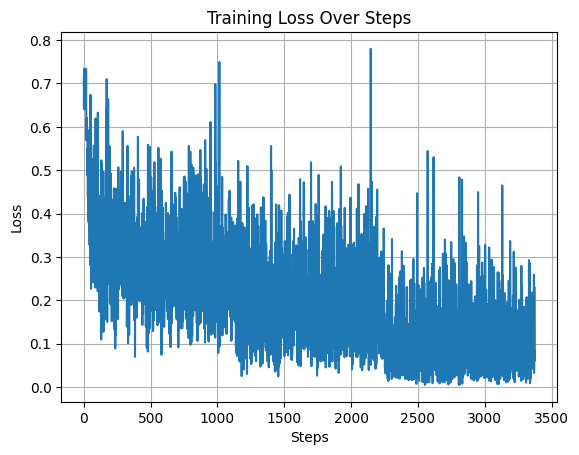

In [19]:
plt.plot(train_losses)
plt.title("Training Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid()
plt.show()

- Confusion Matrix

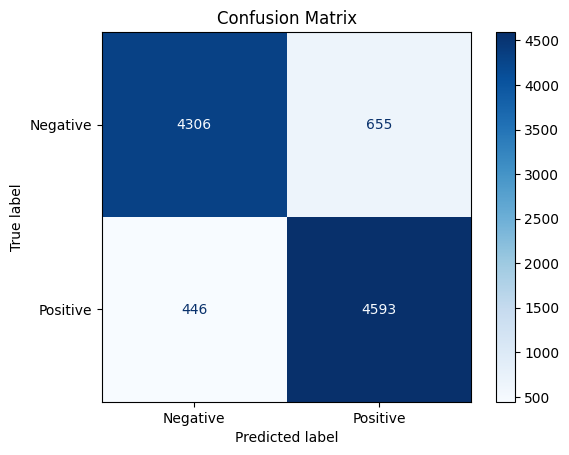

In [20]:
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

- Classification Report as Table

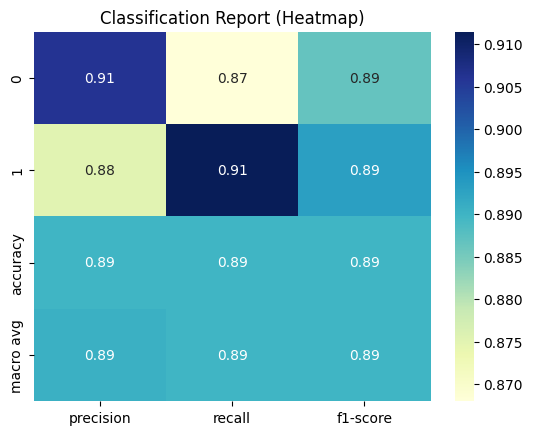

In [21]:
report_dict = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report (Heatmap)")
plt.show()

### Step 5: Prediciton Example

- Test with few Examples

In [22]:
examples = [
    "This movie was absolutely fantastic! The acting was superb and the story was captivating.",
    "I found this film to be quite boring and the plot was predictable. Not a fan.",
    "It had some good moments, but overall it was just okay."
]

In [23]:
for review in examples:
    sentiment = utils.predict_sentiment(model, tokenizer, device, MAX_LENGTH, review)
    print(f"Review: {review} -> Sentiment: {sentiment}")

Review: This movie was absolutely fantastic! The acting was superb and the story was captivating. -> Sentiment: Positive
Review: I found this film to be quite boring and the plot was predictable. Not a fan. -> Sentiment: Negative
Review: It had some good moments, but overall it was just okay. -> Sentiment: Negative


### Step 6: Exporting the model

In [27]:
os.makedirs('models', exist_ok=True)

In [28]:
now = datetime.now()
timestamp = now.strftime("%d%m_%H%M%S")
export_model_name = f"sentiment_analysis_model_{EPOCHS}EP_{timestamp}.pth"
torch.save(model.state_dict(), MODEL_DIR + export_model_name)
tokenizer.save_pretrained(MODEL_DIR + "tokenizer")

('models/tokenizer/tokenizer_config.json',
 'models/tokenizer/special_tokens_map.json',
 'models/tokenizer/vocab.txt',
 'models/tokenizer/added_tokens.json')

In [29]:
config = {
    "model_name": export_model_name,
    "epochs": EPOCHS,
    "max_length": MAX_LENGTH,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "accuracy": accuracy,
    "f1_score": f1
}

In [30]:
with open(MODEL_DIR + "model_config.json", "w") as f:
    json.dump(config, f)

print("Model and config saved successfully.")

Model and config saved successfully.


In [31]:
!jupyter nbconvert --to script train_model.ipynb

[NbConvertApp] Converting notebook train_model.ipynb to script
[NbConvertApp] Writing 7136 bytes to train_model.py


In [33]:
!jupyter nbconvert --to html train_model.ipynb

[NbConvertApp] Converting notebook train_model.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 464038 bytes to train_model.html
